<a href="https://colab.research.google.com/github/Momentum1ab/MomentumScreener/blob/main/RRG_Animation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


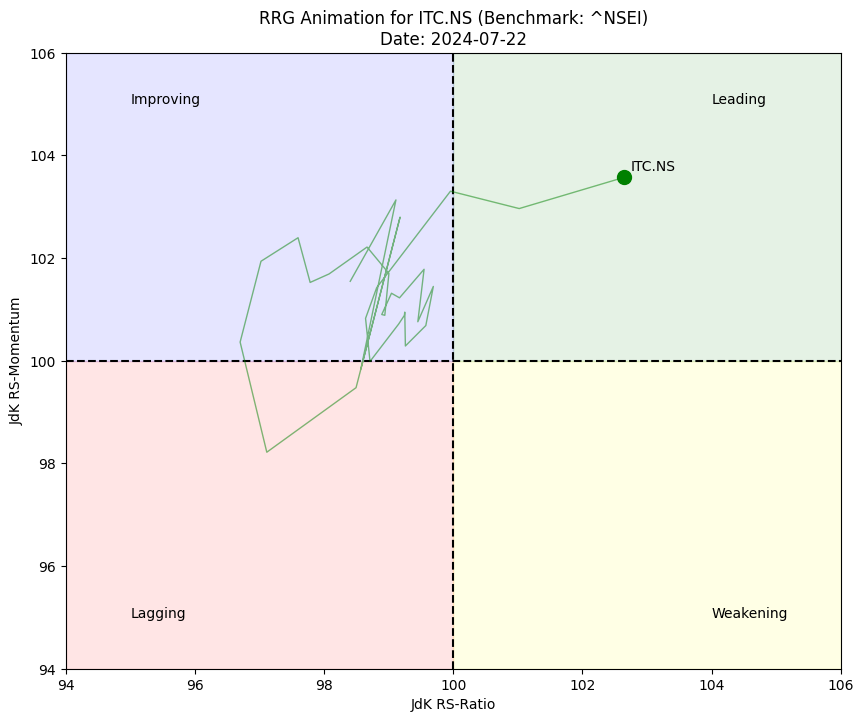

In [4]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

def get_status(x, y):
    if x < 100 and y < 100:
        return 'lagging'
    elif x > 100 and y > 100:
        return 'leading'
    elif x < 100 and y > 100:
        return 'improving'
    elif x > 100 and y < 100:
        return 'weakening'

def get_color(x, y):
    if get_status(x, y) == 'lagging':
        return 'red'
    elif get_status(x, y) == 'leading':
        return 'green'
    elif get_status(x, y) == 'improving':
        return 'blue'
    elif get_status(x, y) == 'weakening':
        return 'yellow'

class RRGSingleTickerAnimator:
    def __init__(self, benchmark, ticker, period='2y', window=26):
        self.benchmark = benchmark
        self.ticker = ticker
        self.period = period
        self.window = window
        self.load_data()
        self.calculate_rrg()
        self.create_plot()

    def load_data(self):
        self.ticker_data = yf.download(self.ticker, period=self.period, interval="1wk")['Adj Close']
        self.benchmark_data = yf.download(self.benchmark, period=self.period, interval="1wk")['Adj Close']

        # Align the data
        self.ticker_data, self.benchmark_data = self.ticker_data.align(self.benchmark_data, join='inner')

    def calculate_rrg(self):
        rs = 100 * (self.ticker_data / self.benchmark_data)
        self.rsr = (100 + (rs - rs.rolling(window=self.window).mean()) / rs.rolling(window=self.window).std(ddof=0)).dropna()
        rsr_roc = 100 * ((self.rsr / self.rsr.shift(1)) - 1)
        self.rsm = (101 + ((rsr_roc - rsr_roc.rolling(window=self.window).mean()) / rsr_roc.rolling(window=self.window).std(ddof=0))).dropna()

        # Align RSR and RSM
        self.rsr, self.rsm = self.rsr.align(self.rsm, join='inner')

    def create_plot(self):
        self.fig, self.ax = plt.subplots(figsize=(10, 8))
        self.ax.set_title(f'RRG Animation for {self.ticker} (Benchmark: {self.benchmark})')
        self.ax.set_xlabel('JdK RS-Ratio')
        self.ax.set_ylabel('JdK RS-Momentum')
        self.ax.axhline(y=100, color='k', linestyle='--')
        self.ax.axvline(x=100, color='k', linestyle='--')
        self.ax.fill_between([94, 100], [94, 94], [100, 100], color='red', alpha=0.1)
        self.ax.fill_between([100, 106], [94, 94], [100, 100], color='yellow', alpha=0.1)
        self.ax.fill_between([100, 106], [100, 100], [106, 106], color='green', alpha=0.1)
        self.ax.fill_between([94, 100], [100, 100], [106, 106], color='blue', alpha=0.1)
        self.ax.text(95, 105, 'Improving', fontsize=10)
        self.ax.text(104, 105, 'Leading', fontsize=10)
        self.ax.text(104, 95, 'Weakening', fontsize=10)
        self.ax.text(95, 95, 'Lagging', fontsize=10)
        self.ax.set_xlim(94, 106)
        self.ax.set_ylim(94, 106)

        self.scatter, = self.ax.plot([], [], 'ro', markersize=10)
        self.line, = self.ax.plot([], [], 'r-', linewidth=1, alpha=0.5)
        self.annotation = self.ax.annotate('', xy=(0, 0), xytext=(5, 5), textcoords='offset points')

    def animate(self, num_frames=None):
        if num_frames is None:
            num_frames = len(self.rsr)

        def update(frame):
            x_data = self.rsr.iloc[max(0, frame-30):frame+1]
            y_data = self.rsm.iloc[max(0, frame-30):frame+1]

            if len(x_data) > 0 and len(y_data) > 0:
                self.line.set_data(x_data, y_data)
                self.scatter.set_data([x_data.iloc[-1]], [y_data.iloc[-1]])  # Use lists for set_data
                color = get_color(x_data.iloc[-1], y_data.iloc[-1])
                self.scatter.set_color(color)
                self.line.set_color(color)
                self.annotation.set_text(self.ticker)
                self.annotation.xy = (x_data.iloc[-1], y_data.iloc[-1])
                date = self.rsr.index[frame].strftime('%Y-%m-%d')
                self.ax.set_title(f'RRG Animation for {self.ticker} (Benchmark: {self.benchmark})\nDate: {date}')

            return self.scatter, self.line, self.annotation

        anim = animation.FuncAnimation(self.fig, update, frames=num_frames, interval=100, blit=True)
        return HTML(anim.to_jshtml())

# Example usage
benchmark = "^NSEI"  # NIFTY50
ticker = "ITC.NS"  # ITC
animator = RRGSingleTickerAnimator(benchmark, ticker, period='2y', window=26)
HTML(animator.animate().data)